# The Simpsons episode data analysis
- Web scraping from wikipedia and IMDB every episode of The Simpsons, as well as writers, directors, and guest stars
- Using pandas and BS4 to import and clean up data from wikipedia, find ratings from IMDB datasets
- Import list of guest stars from wikipedia, crawl each guest's respective article to find whether they're alive
- Visualize data using sns and plt
- Visualize individual episode rating and views, average ratings and views per season
- Visualize writers and directors by season and episode rating
- Visualize guest appearances from both alive and deceased guest stars

## Import and clean data from wikipedia and IMDB

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from urllib.request import urlopen

### Wikipedia episode data

In [2]:
html_1 = urlopen('https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes_(seasons_1-20)')
bs_1 = BeautifulSoup(html_1.read(),'html.parser')

html_2 = urlopen('https://en.wikipedia.org/wiki/List_of_The_Simpsons_episodes')
bs_2 = BeautifulSoup(html_2.read(),'html.parser')

In [12]:
episode_tables = bs_1.find_all('table',{'class':"wikitable plainrowheaders wikiepisodetable"})
episodes = [pd.read_html(str(i))[0] for i in episode_tables if 'The Simpsons Movie' not in str(i)]

episode_tables = bs_2.find_all('table',{'class':"wikitable plainrowheaders wikiepisodetable"})
episodes.extend([pd.read_html(str(i))[0] for i in episode_tables if ('Screenplay by' not in str(i)) and ('Ratings/' not in str(i))])

for i in range(len(episodes)):
    episodes[i]['seasonNumber'] = i+1

episodes_df = pd.concat(episodes[:31]).reset_index(drop=True)

In [14]:
# fix problems with episodes 608

episodes_df.loc[607,['No.overall','No. inseason','Prod.code']]=[608,12,'WABF04']
episodes_df.loc[608:,'No.overall'] -= 1 
episodes_df.loc[608:616,'No. inseason'] -= 1 


# fix problems with 681, 682
old_ep = pd.DataFrame(episodes_df.iloc[679].copy()).transpose()
old_ep[['No.overall','No. inseason','Original air date','Prod.code','U.S. viewers(millions)']] = [680,19,'April 26, 2020','ZABF12','1.35']

new_ep = pd.DataFrame(episodes_df.iloc[679].copy()).transpose()
new_ep[['No.overall','No. inseason','Original air date','Prod.code','U.S. viewers(millions)']] = [681,20,'May 3, 2020','ZABF13','1.36']

episodes_df = pd.concat([episodes_df.iloc[:679],old_ep,new_ep,episodes_df.iloc[680:]]).reset_index(drop=True)

# convert ratings to numerical values
episodes_df['U.S. viewers(millions)'] = pd.to_numeric(episodes_df['U.S. viewers(millions)'].replace('\[.*\]','',regex=True))

# convert dates to datetime
episodes_df['Original air date'] = pd.to_datetime(episodes_df['Original air date'].replace('\[.*\]','',regex=True),infer_datetime_format=True)

#change column names
episodes_df.columns = ['overallNumber', 'episodeNumber', 'Title', 'Directed by', 'Written by',
       'Original air date', 'Prod.code', 'US_viewers_millions',
       'seasonNumber']

### IMDB ratings

In [15]:
imdb_episodes_df = pd.read_csv('./data/episode_data.txt',sep='\t')
imdb_episodes_df = imdb_episodes_df[imdb_episodes_df['parentTconst']=='tt0096697']
imdb_episodes_df['seasonNumber'] = pd.to_numeric(imdb_episodes_df['seasonNumber'])
imdb_episodes_df['episodeNumber'] = pd.to_numeric(imdb_episodes_df['episodeNumber'])
imdb_episodes_df = imdb_episodes_df.sort_values(['seasonNumber','episodeNumber']).reset_index(drop=True)

In [16]:
imdb_ratings_df = pd.read_csv('./data/rating_data.txt',sep='\t')
imdb_df = imdb_episodes_df.merge(imdb_ratings_df,on='tconst',how='inner')

### Combine dfs

In [17]:
simpsons_df = episodes_df.merge(imdb_df,on=['seasonNumber','episodeNumber'],how='inner').drop(['Directed by', 'Written by','parentTconst',],axis=1)
simpsons_df['Title'] = simpsons_df['Title']
simpsons_df

,overallNumber,episodeNumber,Title,Original air date,Prod.code,US_viewers_millions,seasonNumber,tconst,averageRating,numVotes
0,1,1,"""Simpsons Roasting on an Open Fire""",1989-12-17,7G08,26.70,1,tt0348034,8.2,6326
1,2,2,"""Bart the Genius""",1990-01-14,7G02,24.50,1,tt0756593,7.7,4154
2,3,3,"""Homer's Odyssey""",1990-01-21,7G03,27.50,1,tt0701124,7.4,3664
3,4,4,"""There's No Disgrace Like Home""",1990-01-28,7G04,20.20,1,tt0756399,7.7,3594
4,5,5,"""Bart the General""",1990-02-04,7G05,27.10,1,tt0701059,8.0,3639
...,...,...,...,...,...,...,...,...,...,...
700,701,18,"""Burger Kings""",2021-04-11,QABF11,1.24,32,tt13977692,6.8,277
701,702,19,"""Panic on the Streets of Springfield""",2021-04-18,QABF12,1.31,32,tt13977716,6.2,380
702,703,20,"""Mother and Child Reunion""",2021-05-09,QABF14,1.11,32,tt14056918,7.1,248
703,704,21,"""The Man from G.R.A.M.P.A.""",2021-05-16,QABF13,1.06,32,tt14056916,6.4,213


### Director and writer dfs

In [18]:
# Episode number and their respective writers, regex to separate joined names
episode_writer = pd.concat([episodes_df['overallNumber'],episodes_df['Written by'].replace('\[.*\]','',regex=True)],axis=1,keys=['overallNumber','Written by'])

re_pattern = r' & |, | and |Story by: |Teleplay by: | \(wraparounds\)'
re_pattern_joinednames = r'([a-z]{2})([A-Z]{1})'
for i in range(len(episode_writer)):
    
    cond = re.search(re_pattern+'|'+re_pattern_joinednames, episode_writer.loc[i,'Written by'])

    if cond:
        s = episode_writer.loc[i,'Written by'].replace(u'\u200a', '')
        
        clean = re.compile(r'([a-z]{2})([A-Z]{1})')
        s = re.sub(clean,r'\1 & \2',s)
        
        names = re.split(re_pattern, s)
        names = list(filter(None,names))
        
        for n in names:
            episode_writer = episode_writer.append({'overallNumber':episode_writer.loc[i,'overallNumber'],'Written by':n},ignore_index=True)
        episode_writer.loc[i,:] = [pd.NA,pd.NA]

episode_writer=episode_writer.sort_values('overallNumber').dropna().reset_index(drop=True)
episode_writer.iloc[:10]

,overallNumber,Written by
0,1,Mimi Pond
1,2,Jon Vitti
2,3,Wallace Wolodarsky
3,3,Jay Kogen
4,4,Mike Reiss
5,4,Al Jean
6,5,John Swartzwelder
7,6,Mike Reiss
8,6,Al Jean
9,7,John Swartzwelder


In [19]:
# Episode number and their respective directors, regex to separate joined names
episode_director = pd.concat([episodes_df['overallNumber'],episodes_df['Directed by'].replace('\[.*\]','',regex=True)],axis=1,keys=['overallNumber','Directed by'])

re_pattern = r' & |, | and |Story by: |Teleplay by: | \(wraparounds\)'
re_pattern_joinednames = r'([a-z]{2})([A-Z]{1})'
for i in range(len(episode_director)):
    
    cond = re.search(re_pattern+'|'+re_pattern_joinednames, episode_director.loc[i,'Directed by'])

    if cond:
        s = episode_director.loc[i,'Directed by'].replace(u'\u200a', '')
        
        clean = re.compile(r'([a-z]{2})([A-Z]{1})')
        s = re.sub(clean,r'\1 & \2',s)
        
        names = re.split(re_pattern, s)
        names = list(filter(None,names))
        
        for n in names:
            episode_director = episode_director.append({'overallNumber':episode_director.loc[i,'overallNumber'],'Directed by':n},ignore_index=True)
        episode_director.loc[i,:] = [pd.NA,pd.NA]

episode_director=episode_director.sort_values('overallNumber').dropna().reset_index(drop=True)
episode_director.iloc[670:750]

,overallNumber,Directed by
670,649,Rob Oliver
671,650,Chris Clements
672,651,Matthew Nastuk
673,652,Timothy Bailey
674,653,Mark Kirkland
675,654,Steven Dean Moore
676,655,Rob Oliver
677,656,Chris Clements
678,657,Jennifer Moeller
679,658,Michael Polcino


### Guest stars

In [32]:
# Retrieve all guest star appearances
url = ['https://en.wikipedia.org/wiki/List_of_The_Simpsons_guest_stars_(seasons_1-20)',
        'https://en.wikipedia.org/wiki/List_of_The_Simpsons_guest_stars']
bs = [BeautifulSoup(urlopen(x).read(),'html.parser') for x in url]

guest_star_df = [b.find('table',{'class':"sortable wikitable plainrowheaders"}) for b in bs]
guest_star_df = [pd.read_html(str(t))[0] for t in guest_star_df]
guest_star_df = pd.concat(guest_star_df).reset_index(drop=True).drop(['Season','No.','Episode title'],axis=1)
guest_star_df.columns = ['Guest star','Role(s)','Prod.code']

# Fix episode issues
guest_star_df.loc[guest_star_df['Prod.code'].str.contains('WABF05'),'Prod.code'] = 'WABF04'
guest_star_df = guest_star_df.merge(simpsons_df[['overallNumber','Prod.code']],on='Prod.code',how='inner')
guest_star_df = guest_star_df.drop('Prod.code',axis=1)
guest_star_df['Guest star'] = guest_star_df['Guest star'].replace('\[.*\]|\(.*\)| \[.*\]| \(.*\)','',regex=True)
guest_star_df

,Guest star,Role(s),overallNumber
0,Marcia Wallace,Edna Krabappel Ms. Melon,2
1,Sam McMurray,Worker,3
2,Marcia Wallace,Edna Krabappel,3
3,Miriam Flynn,Ms. Barr,6
4,Ron Taylor,Bleeding Gums Murphy,6
...,...,...,...
1492,Maurice LaMarche,Orson Welles,704
1493,Dmitry Malanitchev,Russian See 'n Say,704
1494,Cesar Mazariegos,Grampa Baby,705
1495,Ian McShane,Artemis,705


In [21]:
# Crawl guest star articles and check if alive or deceased - takes a while
guest_links = bs[0].find('table',{'class':"sortable wikitable plainrowheaders"}).find_all('th',{'scope':'row'})
guest_links.extend(bs[1].find('table',{'class':"sortable wikitable plainrowheaders"}).find_all('th',{'scope':'row'}))
guest_links = [a.find('a',href=re.compile('^(\/wiki\/).*')) for a in guest_links]
guest_links = list(set(filter(None,guest_links)))

guest_alive = pd.DataFrame(columns=['Guest star','Alive'])
for link in guest_links:
    url = f'http://en.wikipedia.org{link.attrs["href"]}'
    try:
        bs_link = BeautifulSoup(urlopen(url).read(),'html.parser')
    except:
        continue
    alive = bs_link.find('th',{'class':'infobox-label'},text='Died') is None
    if alive:
        alive = bs_link.find('th',{'scope':'row'},text='Date of death') is None
    guest_alive = guest_alive.append({'Guest star':link.text,'Alive':alive},ignore_index=True)

guest_alive['Guest star'] = guest_alive['Guest star'].replace('\[.*\]|\(.*\)| \[.*\]| \(.*\)','',regex=True)

guest_star_df = guest_star_df.merge(guest_alive,on='Guest star',how='left')
guest_star_df

,Guest star,Role(s),overallNumber,Alive
0,Marcia Wallace,Edna Krabappel Ms. Melon,2,False
1,Sam McMurray,Worker,3,True
2,Marcia Wallace,Edna Krabappel,3,False
3,Miriam Flynn,Ms. Barr,6,True
4,Ron Taylor,Bleeding Gums Murphy,6,False
...,...,...,...,...
1498,Maurice LaMarche,Orson Welles,704,True
1499,Dmitry Malanitchev,Russian See 'n Say,704,NaN
1500,Cesar Mazariegos,Grampa Baby,705,NaN
1501,Ian McShane,Artemis,705,True


## EDA and visualization

### Scatter matrix

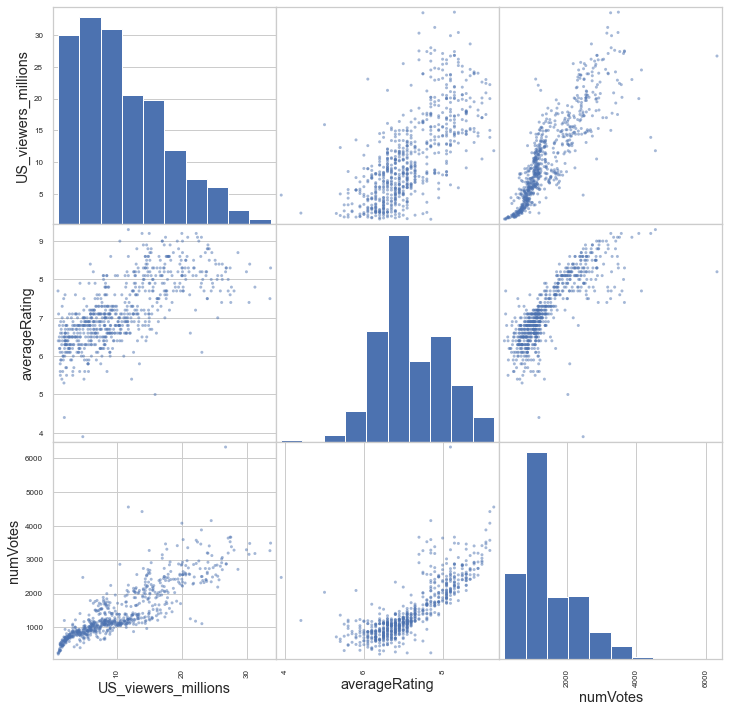

In [185]:
pd.plotting.scatter_matrix(simpsons_df,figsize=(12,12),diagonal='hist')
plt.show()

### Color square diagrams

In [92]:
def plot_color_square(column,label=None):
    if label is None:
        label = column
    episodes_num = simpsons_df.groupby('seasonNumber').count()['episodeNumber'].to_numpy()
    episodes_max = np.max(episodes_num)
    seasons = 32

    square = np.empty([episodes_max,seasons])
    square[:]=np.nan
    
    for s in range(seasons):
        for e in range(episodes_num[s]):
            square[e,s] = simpsons_df[(simpsons_df['seasonNumber']==s+1) & (simpsons_df['episodeNumber']==e+1)][column]


    plt.figure(figsize=(15,15))
    plt.grid(b=True,which='both',alpha=0.3)
    plt.minorticks_on()
    cmap = mpl.cm.get_cmap("RdYlGn").copy()
    cmap.set_bad("white")
    plt.pcolormesh(square,cmap=cmap,edgecolors='k',vmin=np.quantile(simpsons_df[column].dropna(),0.01),vmax=np.quantile(simpsons_df[column].dropna(),0.99))
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0.5,32.5))
    ax.set_xticklabels(range(1,33))
    ax.set_yticks(np.arange(0.5,25.5))
    ax.set_yticklabels(range(1,26))
    plt.colorbar(shrink=0.5).set_label(label)
    plt.ylabel('Episode number')
    plt.xlabel('Season')
    plt.title(label+' for every Simpsons episode')
    plt.show()

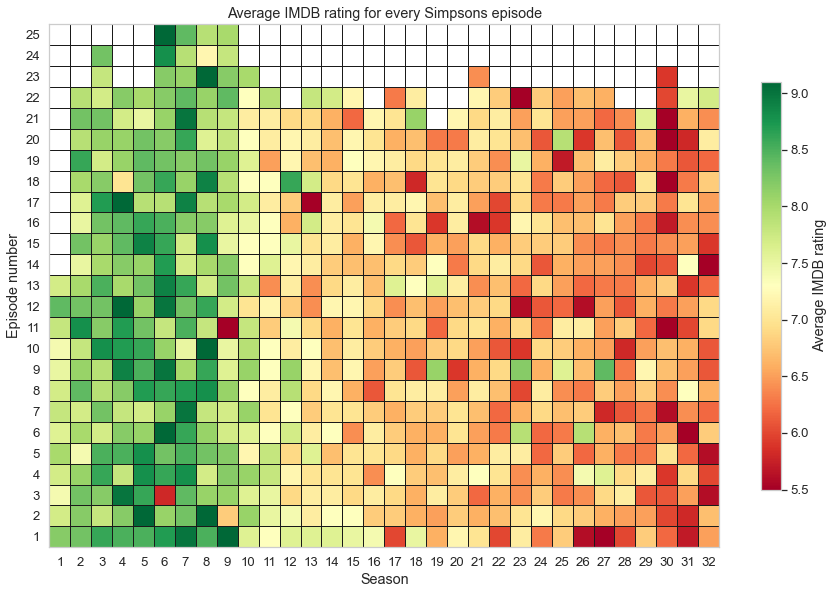

In [93]:
plot_color_square('averageRating','Average IMDB rating')

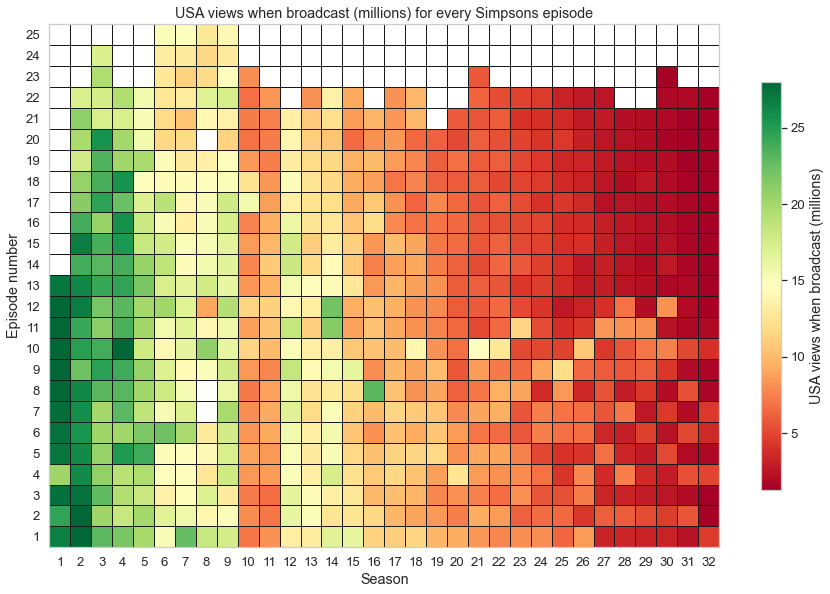

In [94]:
plot_color_square('US_viewers_millions', 'USA views when broadcast (millions)')

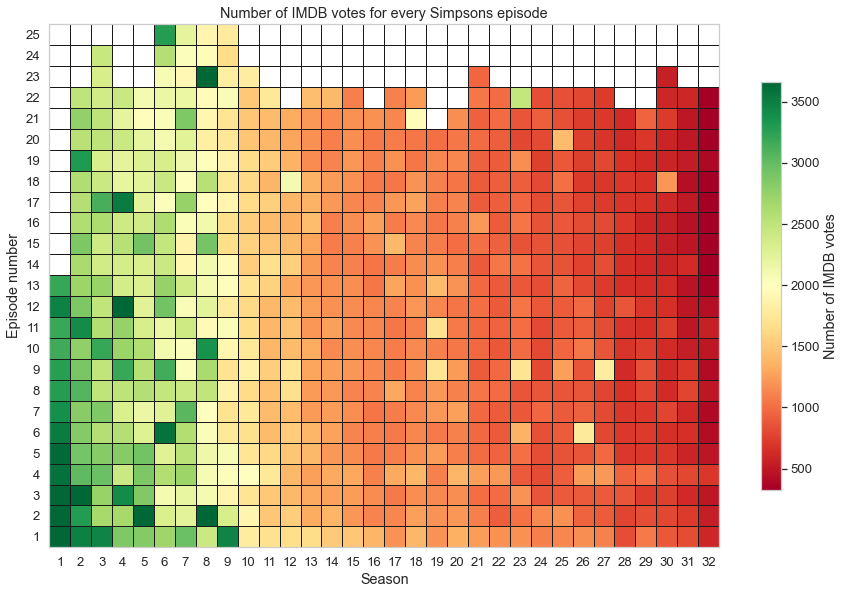

In [95]:
plot_color_square('numVotes', 'Number of IMDB votes')

### Average plots with quantile ranges

In [86]:
def plot_line_quantiles(column,label=None):
    if label is None:
        label = column
    plt.figure(figsize=(12,8))
    sns.set_theme(style='whitegrid',font_scale=1.2)

    avgs = simpsons_df.groupby('seasonNumber').mean()
    stds = simpsons_df.groupby('seasonNumber').std()
    quant = lambda x: simpsons_df.groupby('seasonNumber').quantile(x)

    plt.plot(np.arange(0,32),avgs[column],linewidth=4)
    for i in np.arange(1.5,5.5):
        plt.fill_between(np.arange(0,32),quant(1-i/10)[column],quant(i/10)[column],alpha=0.07,color='blue')

    # plt.plot(np.arange(0,32),avgs['US_viewers_millions'],linewidth=4)
    # plt.fill_between(np.arange(0,32),avgs['US_viewers_millions']-stds['US_viewers_millions'],avgs['US_viewers_millions']+stds['US_viewers_millions'],alpha=0.2)

    plt.grid(b=True,alpha=0.3)
    ax = plt.gca()
    ax.set_xticks(np.arange(0,32))
    ax.set_xticklabels(range(1,33))
    plt.xlim([0,31])
    plt.xlabel('Season')
    plt.ylabel(label)
    plt.title(label+' for every season of The Simpsons')
    
    plt.show()

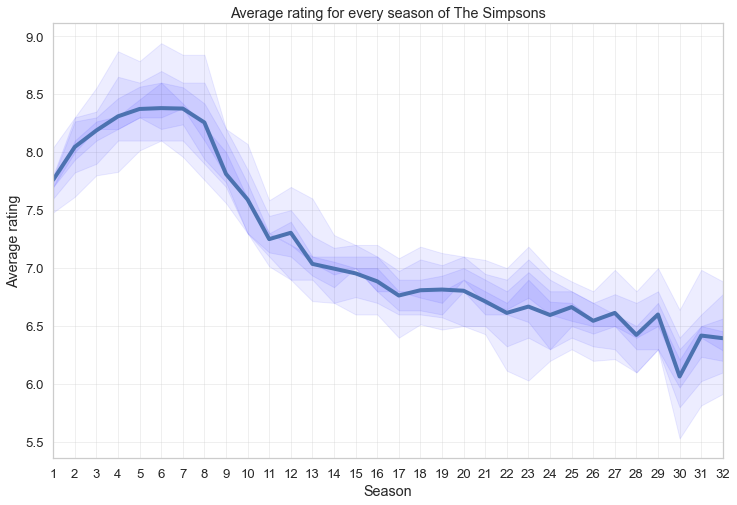

In [87]:
plot_line_quantiles('averageRating', 'Average rating')

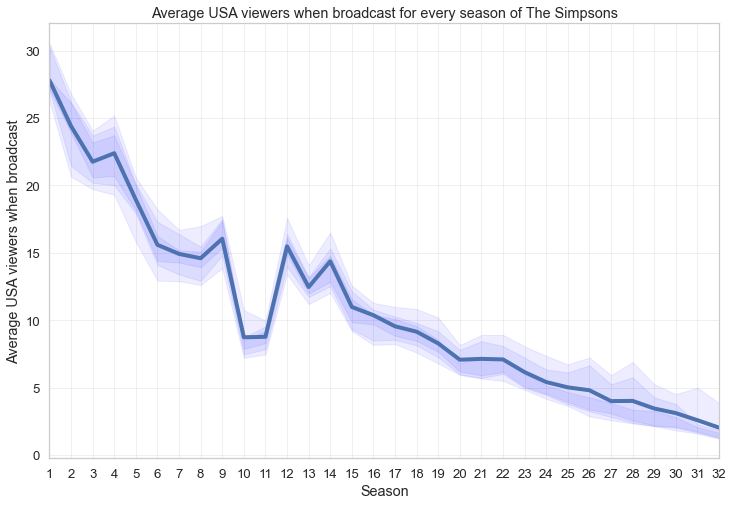

In [83]:
plot_line_quantiles('US_viewers_millions', 'Average USA viewers when broadcast')

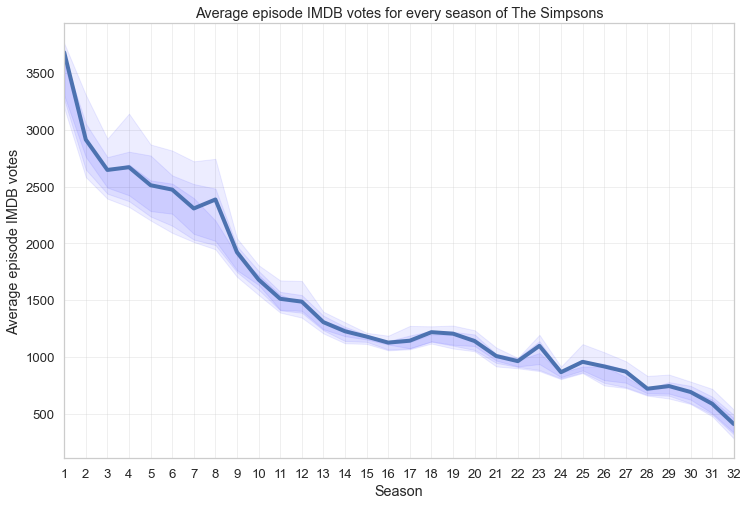

In [85]:
plot_line_quantiles('numVotes', 'Average episode IMDB votes')

### Staff comparisons

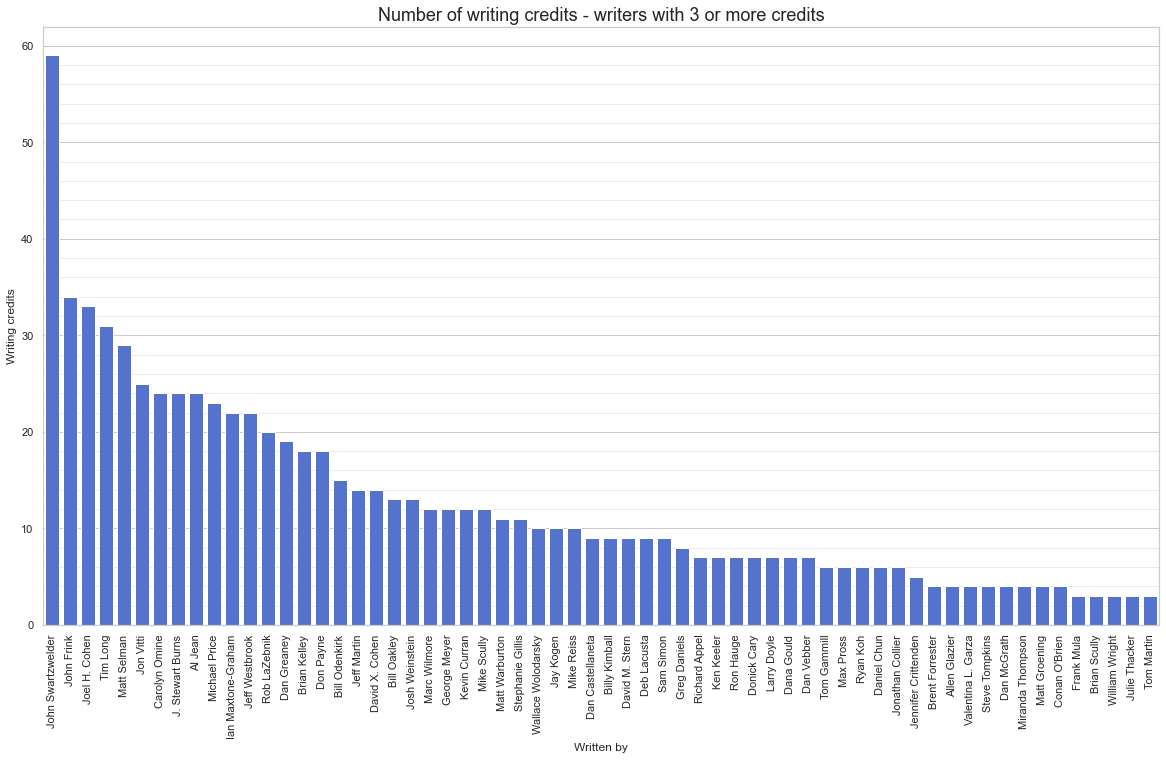

In [83]:
data = episode_writer.groupby('Written by').count().sort_values('overallNumber',ascending=False)
data = data[data['overallNumber']>2]
plt.figure(figsize=(20,11))
sns.set_theme(style='whitegrid')
ax=sns.barplot(x=data.index,y='overallNumber', data=data, color='royalblue')
#ax.tick_params(labelbottom=True,labeltop=True)
plt.xticks(rotation=90)
plt.grid(b=True,which='minor',axis='y',alpha=0.4)
plt.minorticks_on()
plt.ylabel('Writing credits')
plt.title('Number of writing credits - writers with 3 or more credits',fontsize=18)
plt.show()

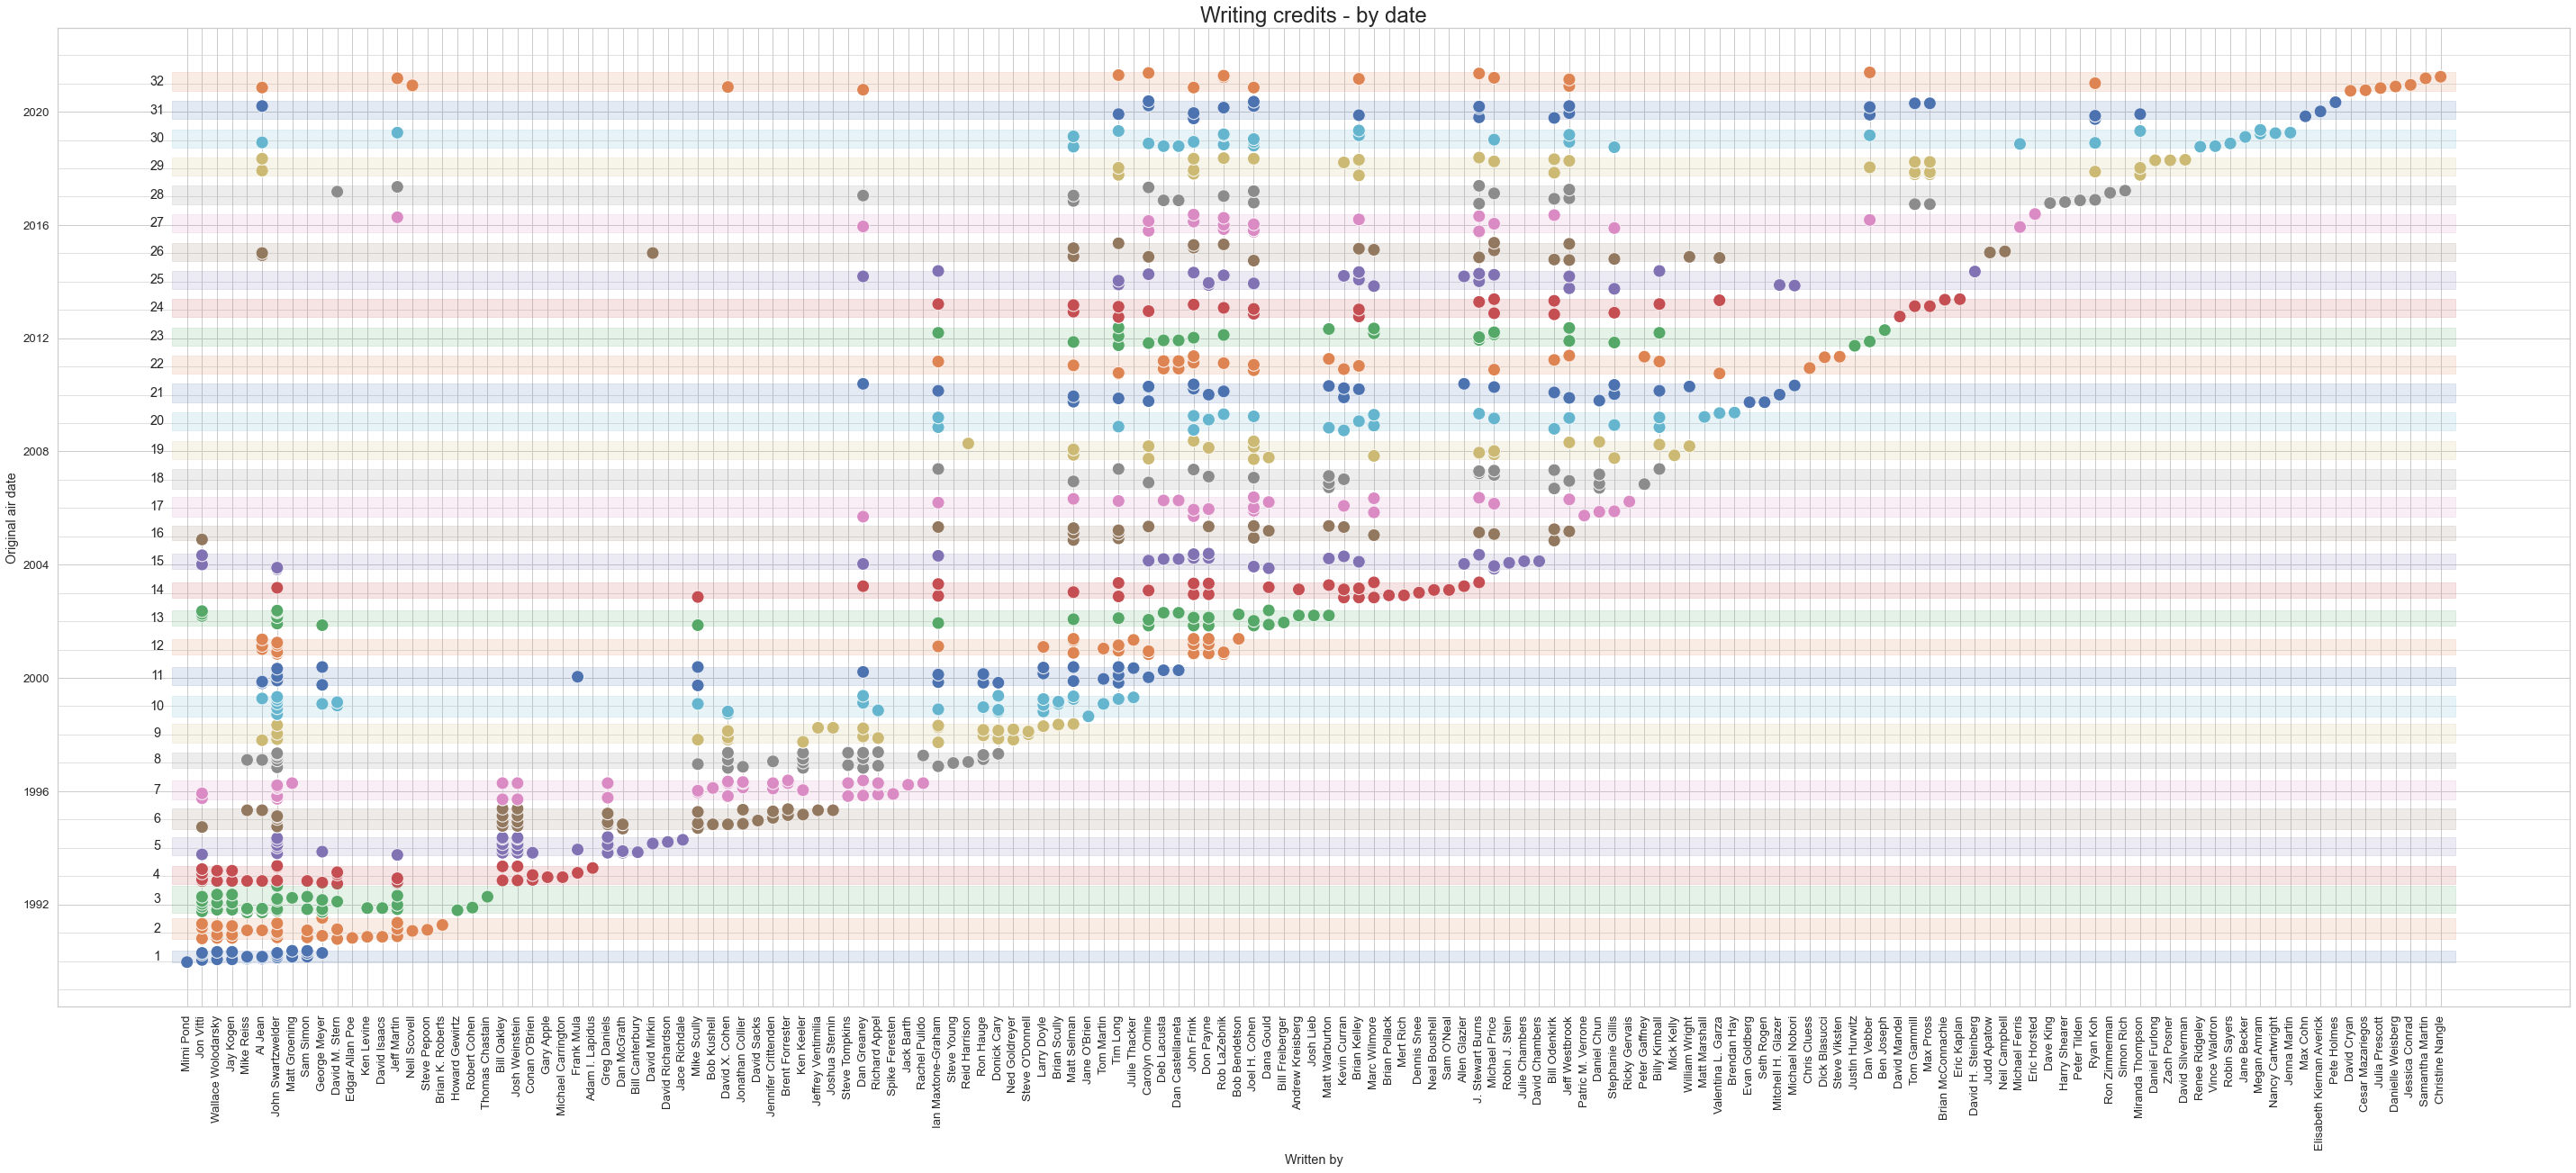

In [159]:
merged_df = simpsons_df.merge(episode_writer,on='overallNumber',how='inner')

plt.figure(figsize=(50,20))
sns.set_theme(style='whitegrid',font_scale=1.2)
ax = sns.scatterplot(x='Written by',
                     y='Original air date',
                     hue=merged_df['seasonNumber'].apply(str),
                     data=merged_df,
                     palette='deep',
                     s=200)

for s in range(1,33):
    season_episodes = merged_df[merged_df['seasonNumber']==s]
    season_dates = [season_episodes['Original air date'].iloc[0],season_episodes['Original air date'].iloc[-1]]
    colors = sns.color_palette('deep')
    plt.fill_between([-1,len(merged_df['Written by'].unique())],season_dates[0],season_dates[1],alpha=0.15,color=colors[(s-1)%10])
    mean = (np.array(season_dates, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    plt.text(-2,mean,str(s),va='center',ha='center')
    
plt.grid(b=True,which='minor',axis='y',alpha=0.6)
plt.minorticks_on()
plt.xticks(rotation=90)
ax.legend().set_visible(False)
plt.title('Writing credits - by date',fontsize=24)
plt.show()

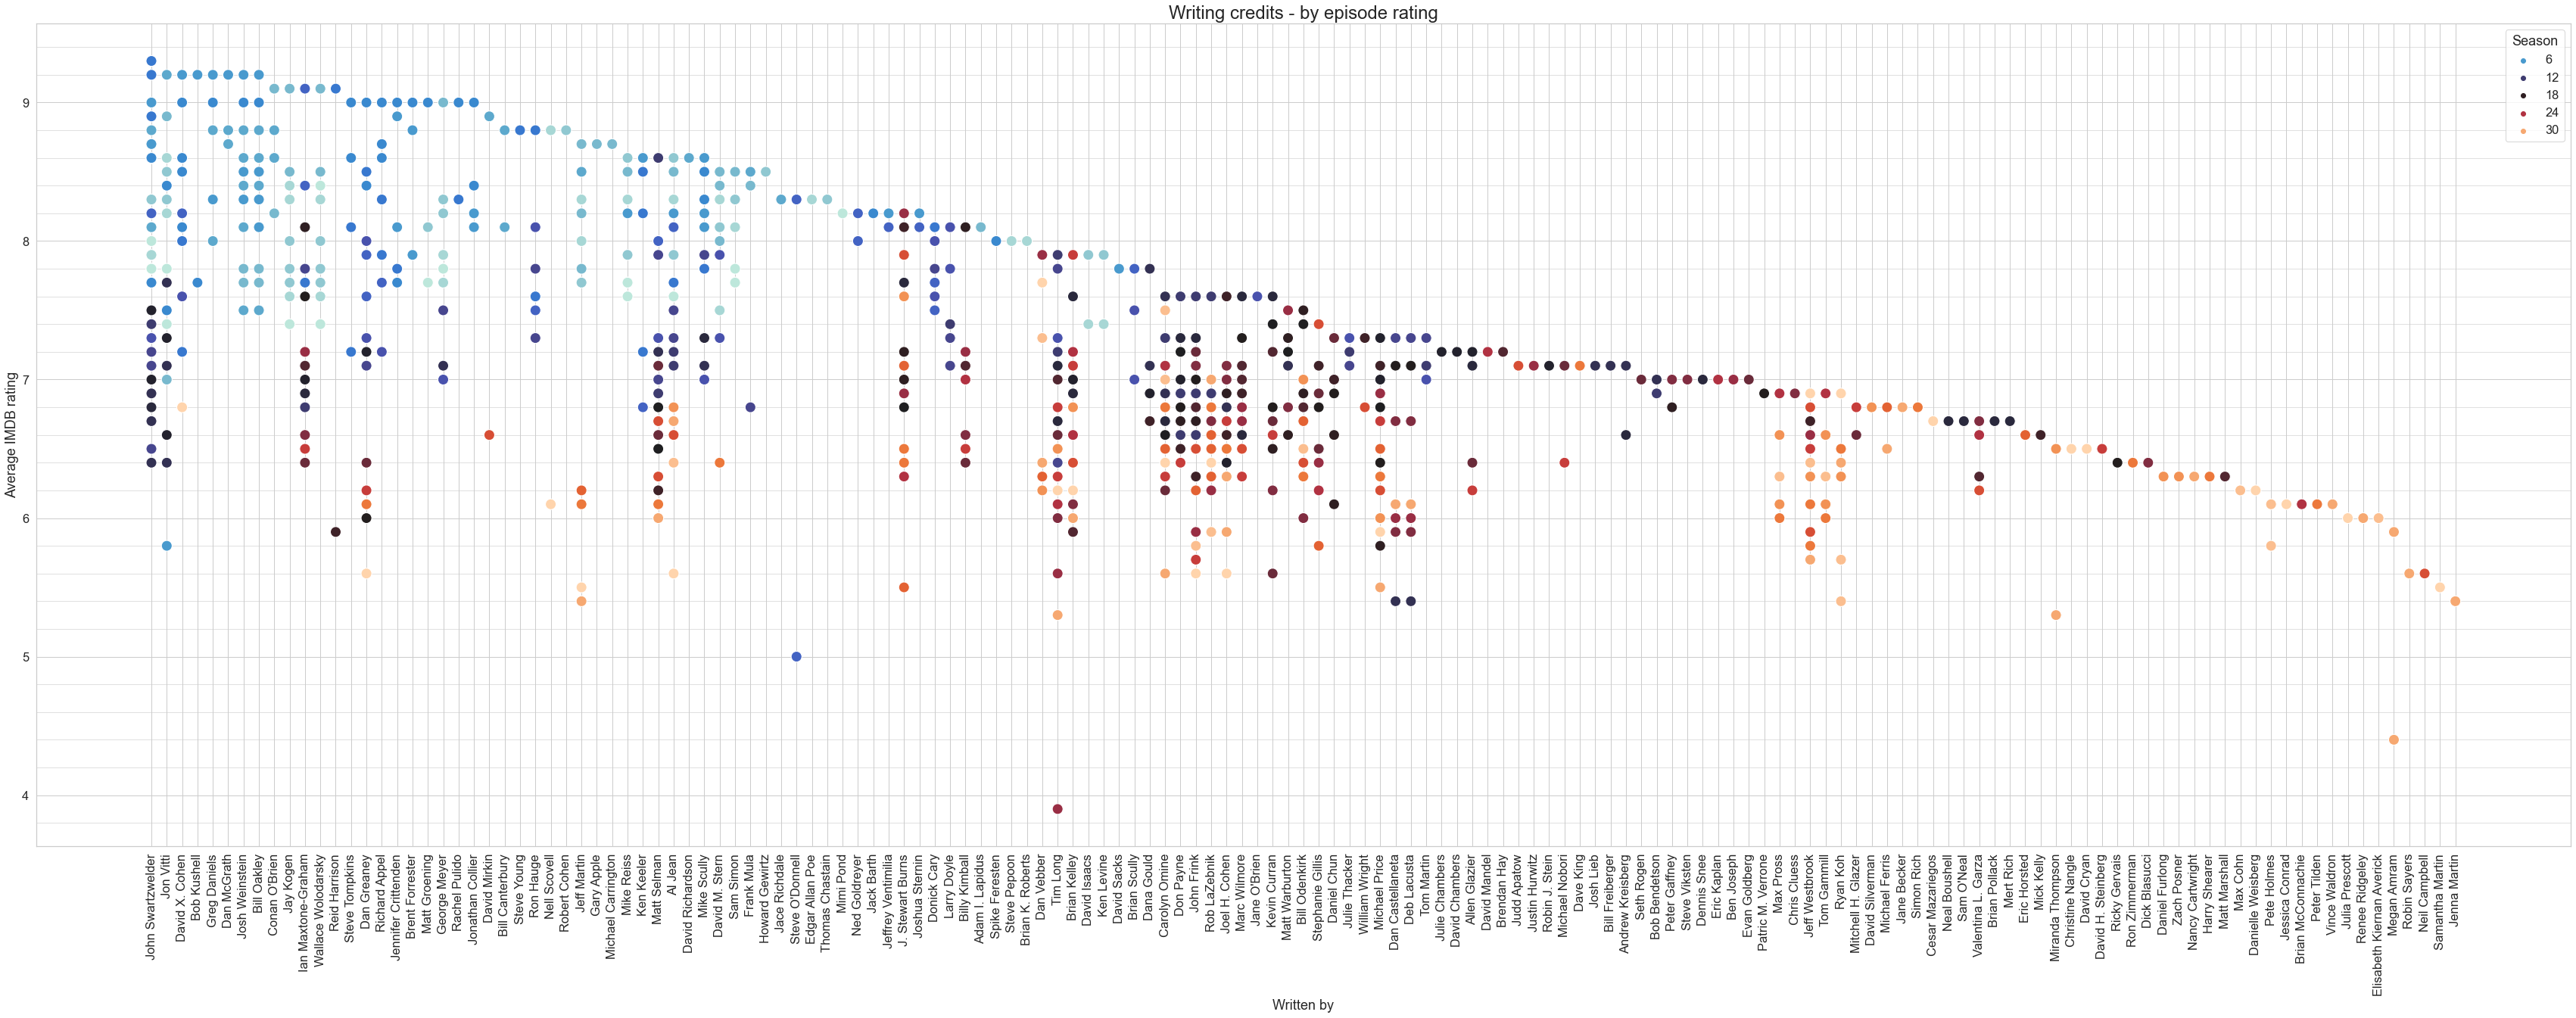

In [100]:
merged_df = simpsons_df.merge(episode_writer,on='overallNumber',how='inner').sort_values('averageRating',ascending=False)

plt.figure(figsize=(60,20))
sns.set_theme(style='whitegrid',font_scale=1.5)
ax = sns.scatterplot(x='Written by',
                     y='averageRating',
                     hue=merged_df['seasonNumber'],
                     data=merged_df,
                     palette='icefire',
                     s=200)
ax.legend_.set_title('Season')
plt.grid(b=True,which='minor',axis='y',alpha=0.6)
plt.minorticks_on()
plt.xticks(rotation=90)
plt.ylabel('Average IMDB rating')
plt.title('Writing credits - by episode rating',fontsize=24)
plt.show()

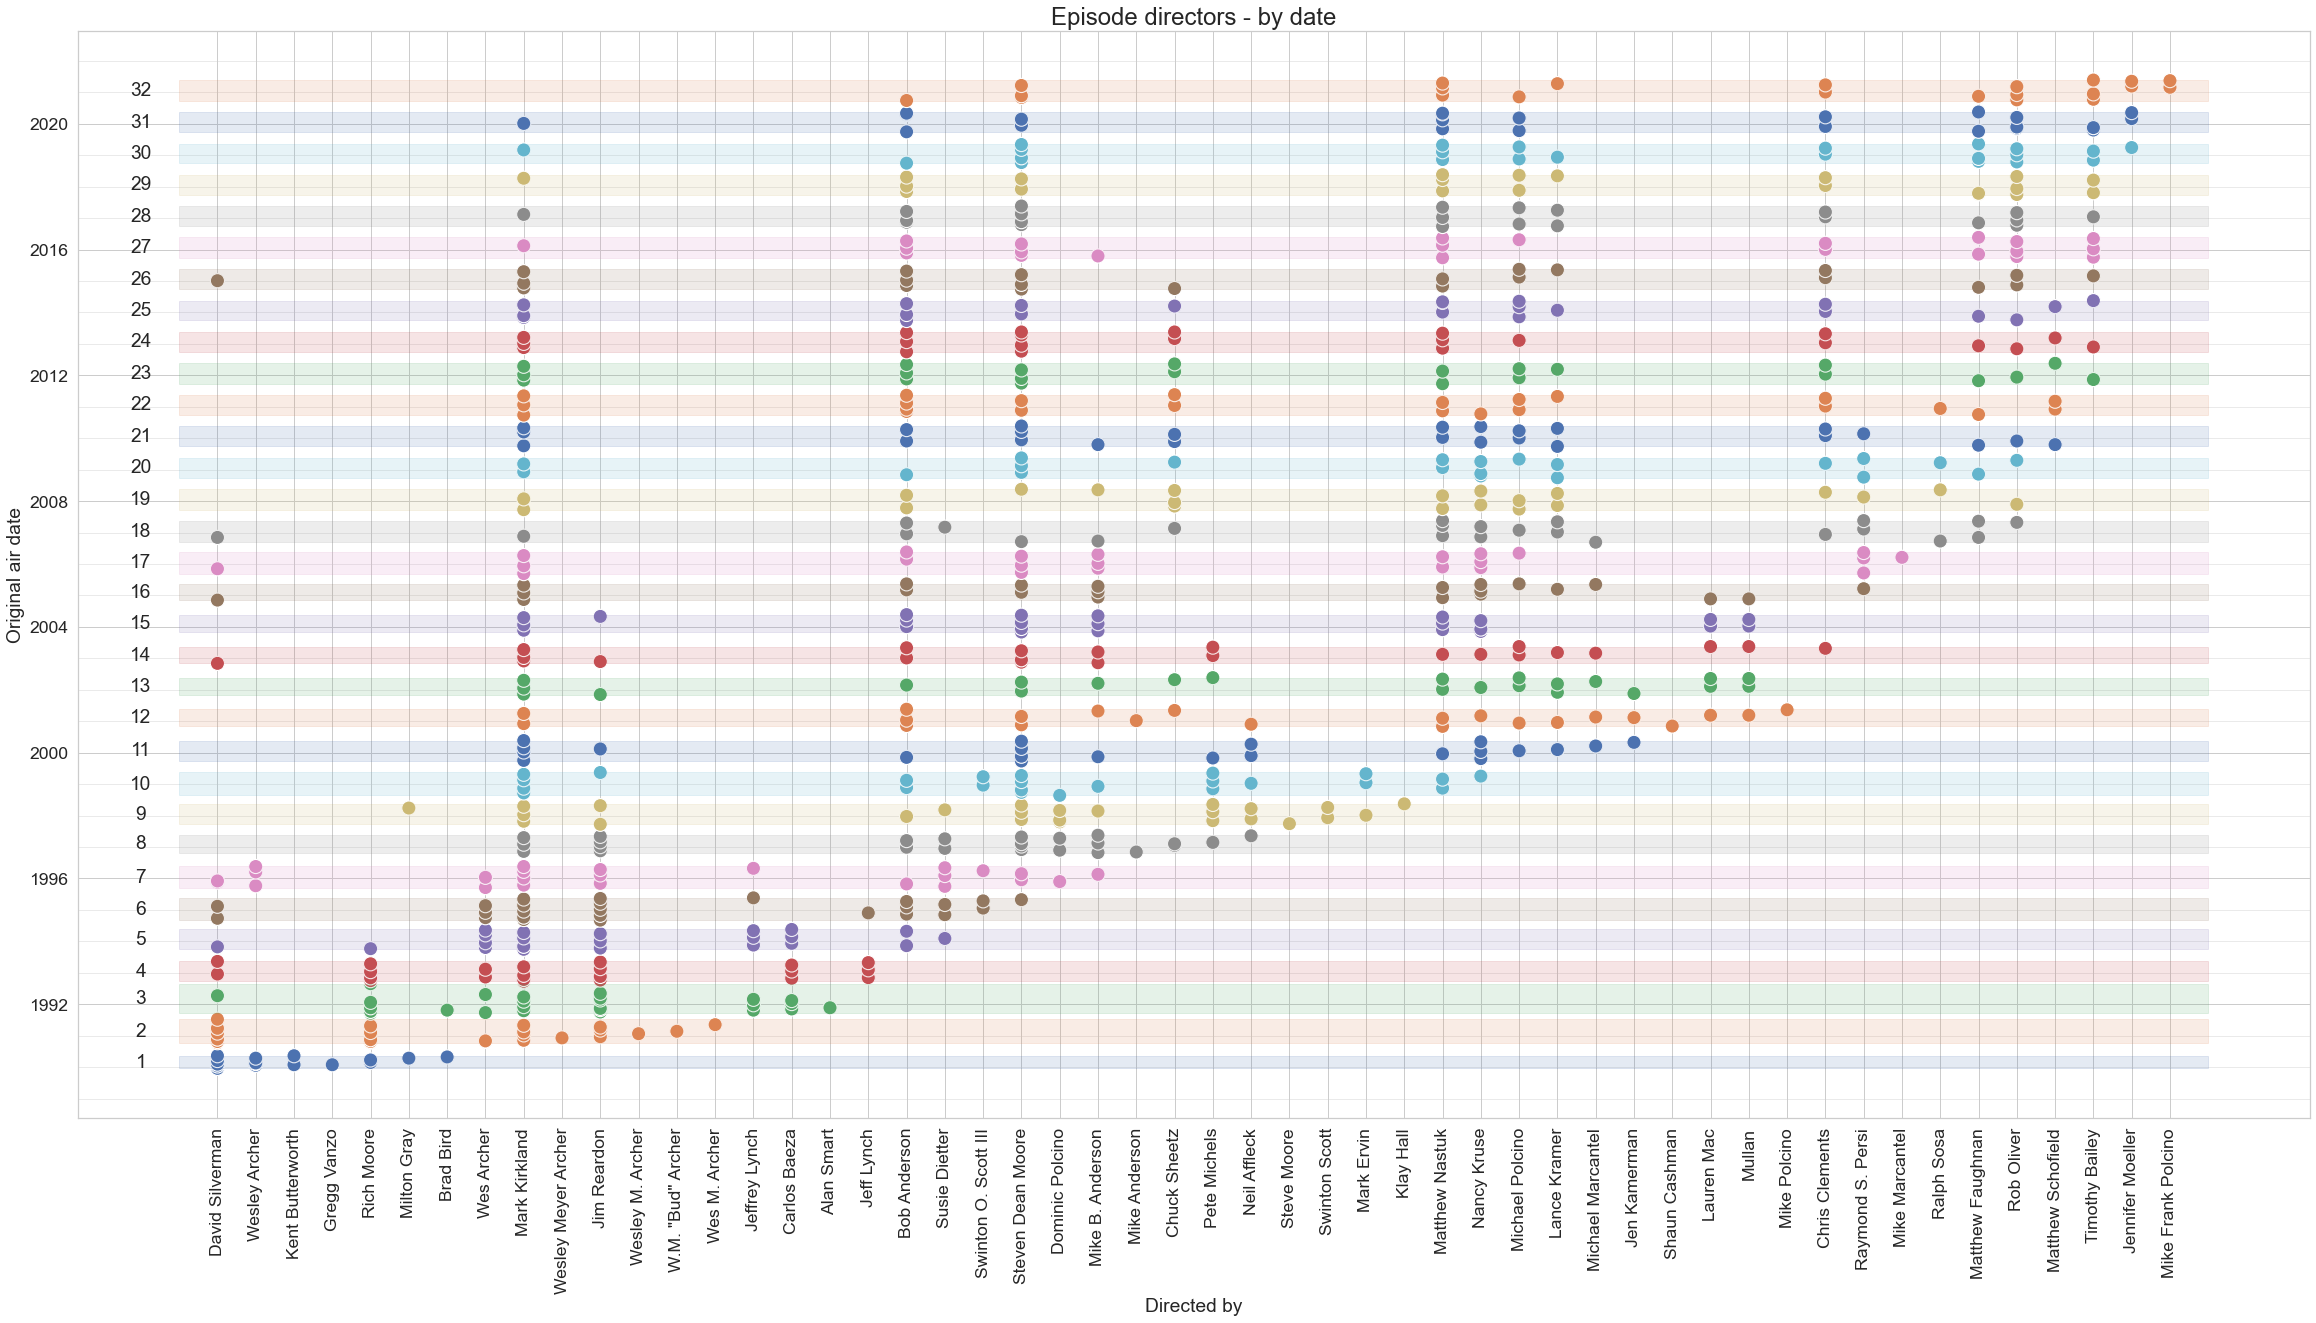

In [162]:
merged_df = simpsons_df.merge(episode_director,on='overallNumber',how='inner')

plt.figure(figsize=(40,20))
sns.set_theme(style='whitegrid',font_scale=1.6)
ax = sns.scatterplot(y='Original air date',
                     x='Directed by',
                     hue=merged_df['seasonNumber'].apply(str),
                     data=merged_df,
                     palette='deep',
                     s=200)

for s in range(1,33):
    season_episodes = merged_df[merged_df['seasonNumber']==s]
    season_dates = [season_episodes['Original air date'].iloc[0],season_episodes['Original air date'].iloc[-1]]
    colors = sns.color_palette('deep')
    plt.fill_between([-1,len(merged_df['Directed by'].unique())],season_dates[0],season_dates[1],alpha=0.15,color=colors[(s-1)%10])
    mean = (np.array(season_dates, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    plt.text(-2,mean,str(s),va='center',ha='center')
plt.grid(b=True,which='minor',axis='y',alpha=0.4)
plt.minorticks_on()
plt.xticks(rotation=90)
ax.legend().set_visible(False)
plt.title('Episode directors - by date',fontsize=24)
plt.show()

### Guest stars

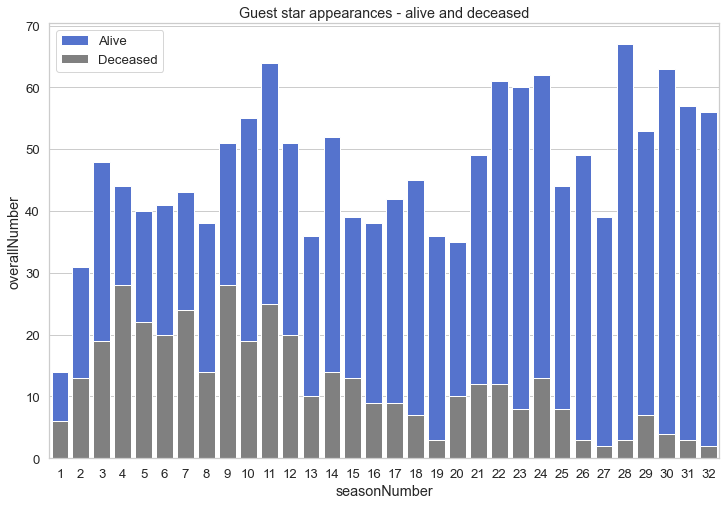

In [61]:
dead_df = simpsons_df[['overallNumber','seasonNumber']].merge(guest_star_df.dropna()[guest_star_df.dropna()['Alive']==False],on='overallNumber',how='inner')
dead_df = dead_df.groupby('seasonNumber').count()

alive_df = simpsons_df[['overallNumber','seasonNumber']].merge(guest_star_df,on='overallNumber',how='inner')
alive_df = alive_df.groupby('seasonNumber').count()

sns.set_theme(style='whitegrid',font_scale=1.2)

ax = plt.subplots(figsize=(12,8))

ax=sns.barplot(x=alive_df.index,y='overallNumber', data=alive_df, color='Royalblue',label='Alive')
ax=sns.barplot(x=dead_df.index,y='overallNumber', data=dead_df, color='grey',label='Deceased')
ax.legend()
plt.title('Guest star appearances - alive and deceased')

plt.show()

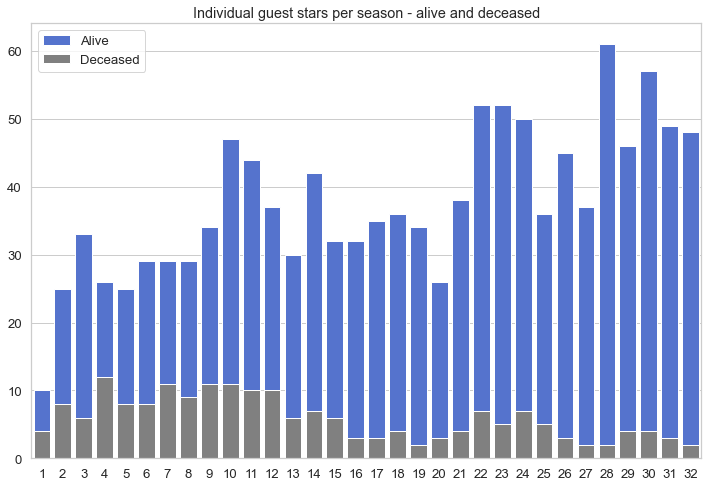

In [62]:
guest_star_episodes = simpsons_df[['overallNumber','seasonNumber']].merge(guest_star_df,on='overallNumber',how='inner')

seasons = list(range(1,33))
total_guests = []
total_deceased = []

for s in seasons:
    s_guests = guest_star_episodes[guest_star_episodes['seasonNumber']==s][['Guest star','Alive']]
    s_guests = s_guests.drop_duplicates()
    total_guests.append(len(s_guests))
    total_deceased.append(len(s_guests[s_guests['Alive']==False]))

sns.set_theme(style='whitegrid',font_scale=1.2)

ax = plt.subplots(figsize=(12,8))

ax=sns.barplot(x=seasons,y=total_guests, color='Royalblue',label='Alive')
ax=sns.barplot(x=seasons,y=total_deceased, color='grey',label='Deceased')
ax.legend()
plt.title('Individual guest stars per season - alive and deceased')

plt.show()

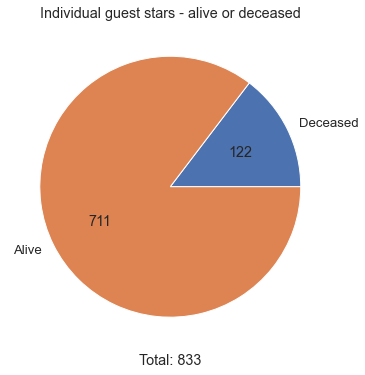

In [120]:
unique_guest_star = guest_star_df[['Guest star','Alive']].drop_duplicates().dropna()
sns.set_theme(style='whitegrid',font_scale=1.2)
abs_val = lambda x: int(np.round(x/100.*len(unique_guest_star),0))
unique_guest_star.groupby('Alive')['Guest star'].count().plot.pie(autopct=abs_val,figsize=(6,6),labels=['Deceased','Alive'])
plt.title('Individual guest stars - alive or deceased')
plt.ylabel('')
plt.xlabel(f'Total: {len(unique_guest_star)}')
plt.show()

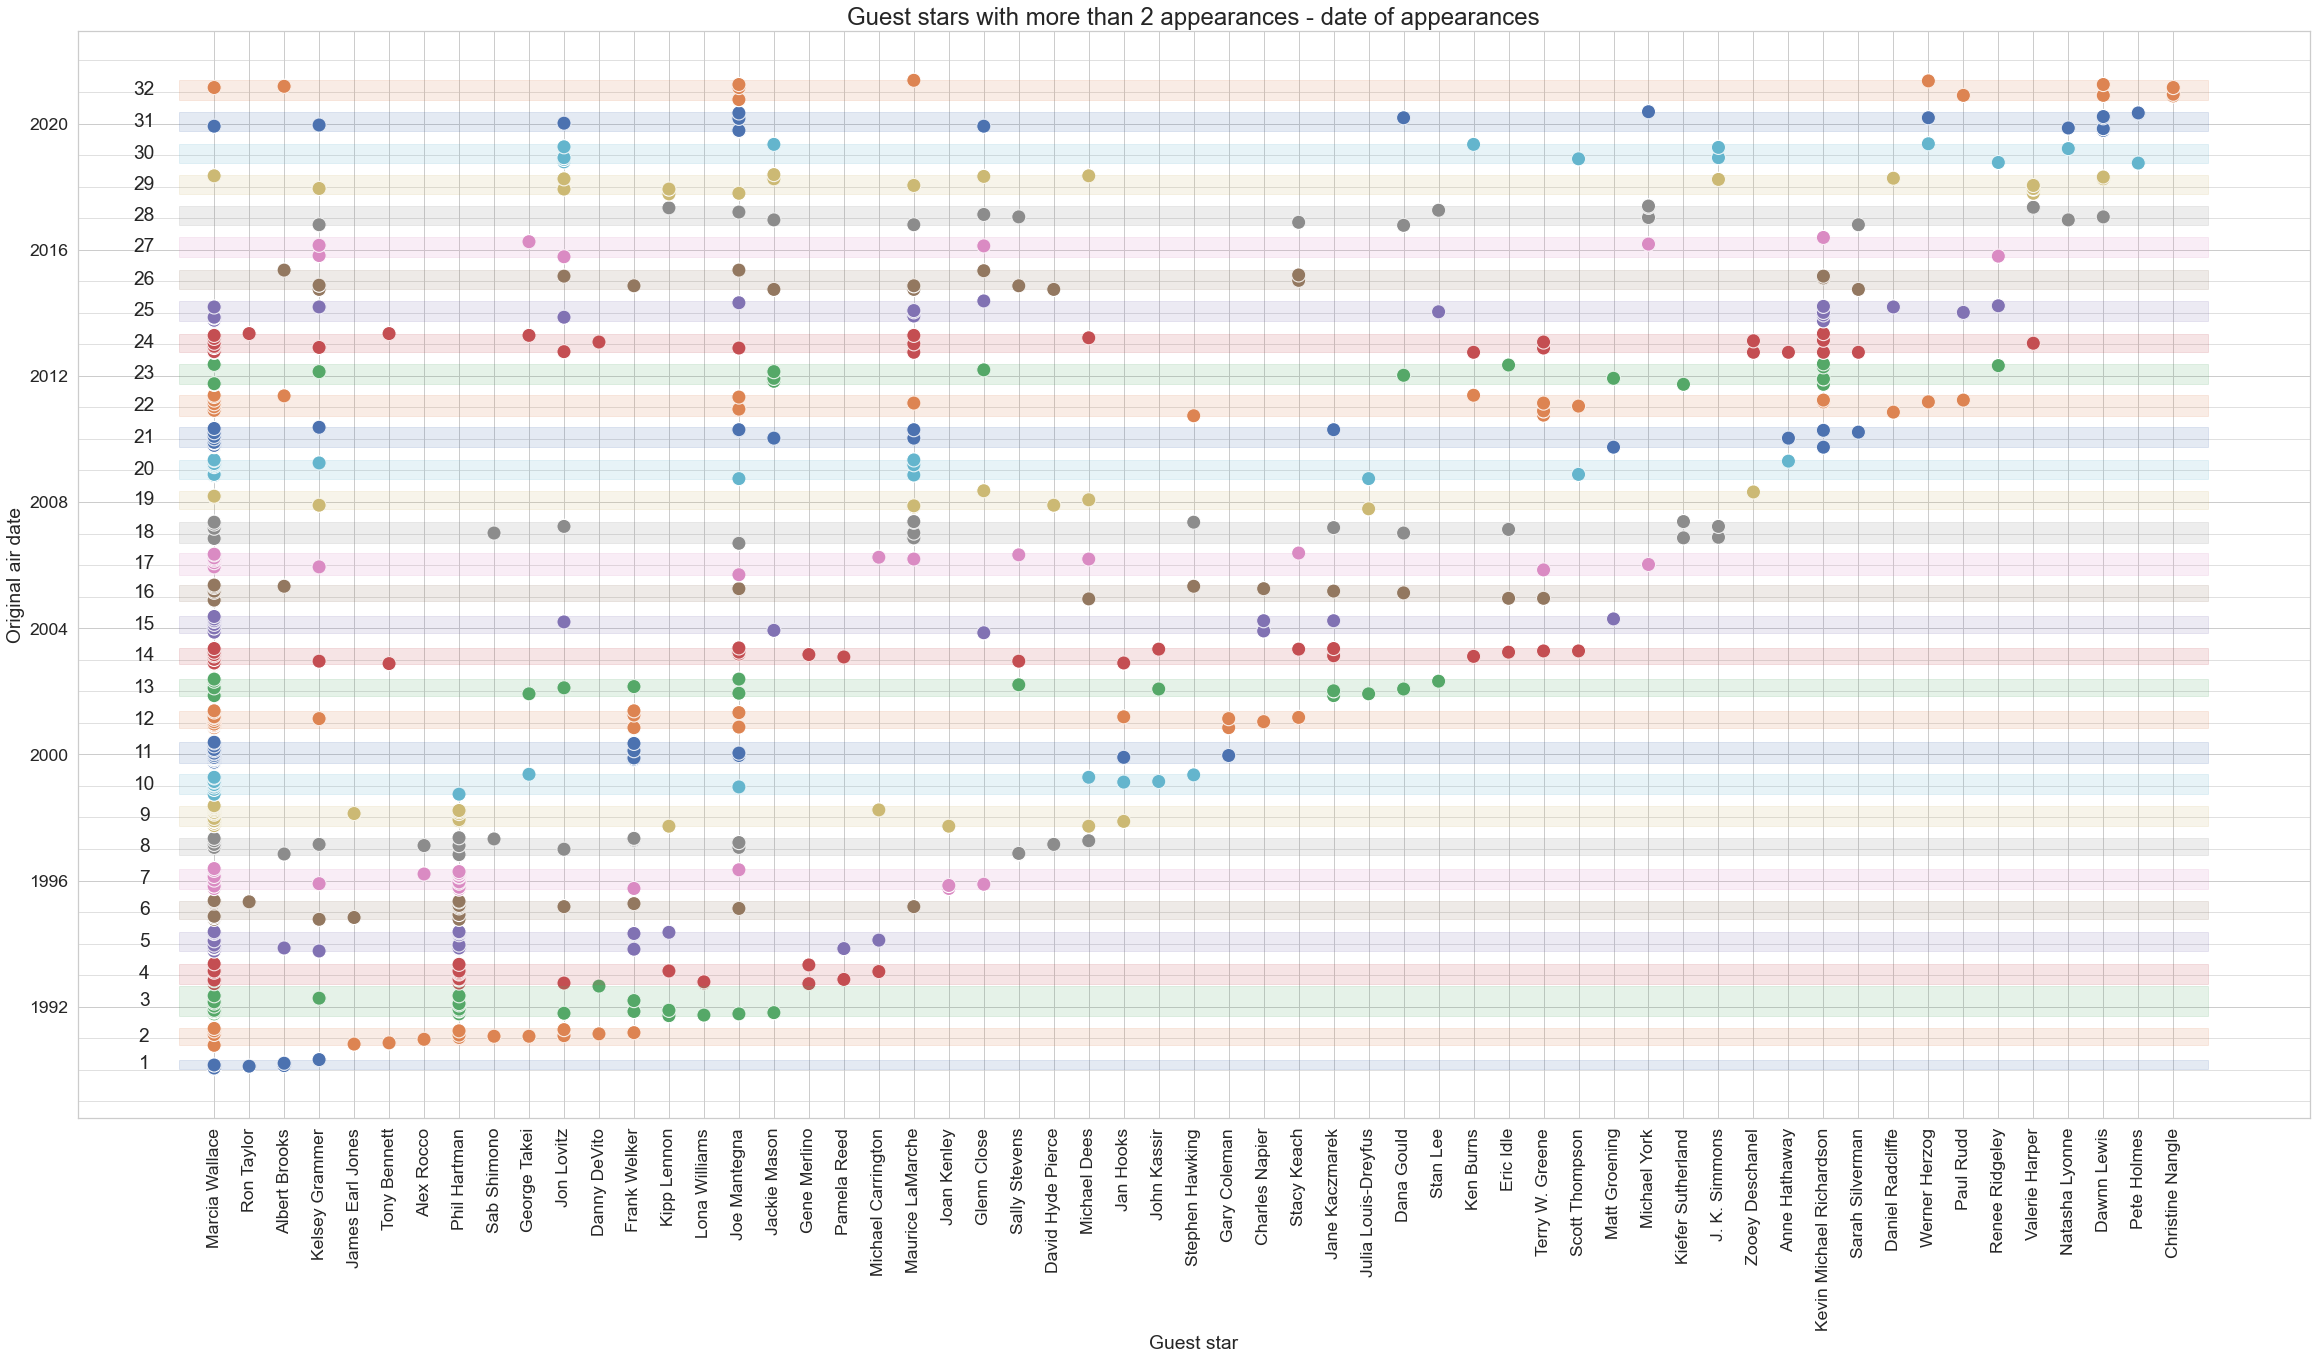

In [163]:
a = guest_star_df.groupby('Guest star').count()
a = a[a['overallNumber']>2]
guest_star_filtered = guest_star_df[guest_star_df['Guest star'].isin(a.index)]

merged_df = simpsons_df.merge(guest_star_filtered,on='overallNumber',how='inner')

plt.figure(figsize=(40,20))
sns.set_theme(style='whitegrid',font_scale=1.6)
ax = sns.scatterplot(x='Guest star',
                     y='Original air date',
                     hue=merged_df['seasonNumber'].apply(str),
                     data=merged_df,
                     palette='deep',
                     s=200)
for s in range(1,33):
    season_episodes = merged_df[merged_df['seasonNumber']==s]
    season_dates = [season_episodes['Original air date'].iloc[0],season_episodes['Original air date'].iloc[-1]]
    colors = sns.color_palette('deep')
    plt.fill_between([-1,len(merged_df['Guest star'].unique())],season_dates[0],season_dates[1],alpha=0.15,color=colors[(s-1)%10])
    mean = (np.array(season_dates, dtype='datetime64[s]')
        .view('i8')
        .mean()
        .astype('datetime64[s]'))
    plt.text(-2,mean,str(s),va='center',ha='center')
plt.grid(b=True,which='minor',axis='y',alpha=0.6)
plt.minorticks_on()
plt.xticks(rotation=90)
ax.legend().set_visible(False)
plt.title('Guest stars with more than 2 appearances - date of appearances',fontsize=24)
plt.show()

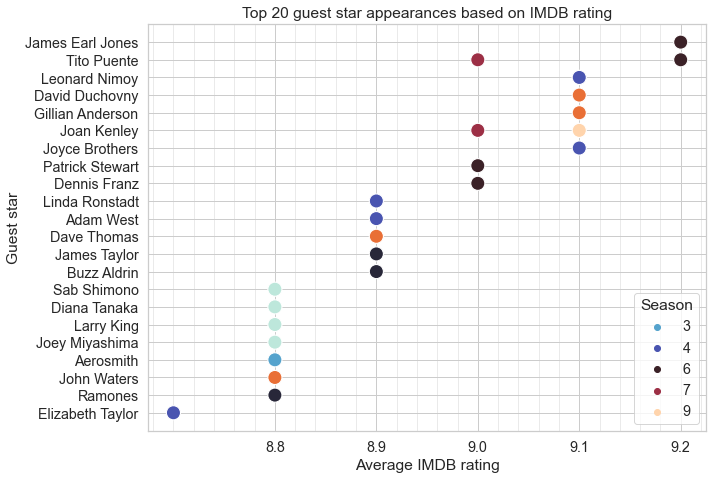

In [72]:
a = guest_star_df.groupby('Guest star').count()
a = a[a['overallNumber']<=3]
guest_star_filtered = guest_star_df[guest_star_df['Guest star'].isin(a.index)]

merged_df = simpsons_df.merge(guest_star_filtered,
                              on='overallNumber',
                              how='inner').sort_values('averageRating',
                                                       ascending=False)[:25]
plt.figure(figsize=(10,7.5))
sns.set_theme(style='whitegrid',font_scale=1.3)
ax = sns.scatterplot(y='Guest star',
                     x='averageRating',
                     hue=merged_df['seasonNumber'],
                     data=merged_df,
                     palette='icefire',
                     s=200)

plt.grid(b=True,which='minor',axis='x',alpha=0.4,)
plt.minorticks_on()
#plt.xticks(rotation=90)
plt.xticks(ticks=np.arange(8.8,9.3,0.1))
ax.legend(title='Season',loc=4)
plt.xlabel('Average IMDB rating')
plt.title('Top 20 guest star appearances based on IMDB rating')
plt.show()